In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))


import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ta.momentum import RSIIndicator

DATA_DIR = '../databases/'

# Coleta e Tratamento de Dados

In [2]:
from utils.core import load_csvs_from_folder
data_dict = load_csvs_from_folder(DATA_DIR)
for ticker in data_dict:
    df_temp = data_dict[ticker]
    df_temp['ret'] = df_temp['close'].pct_change()
    data_dict[ticker] = df_temp

tickers = list(data_dict.keys())
print(f"Loaded datasets: {list(data_dict.keys())}")


Loaded datasets: ['BTCUSD', 'DBC', 'SPX', 'XLRE']


# Construção do Indicador e Sinais

In [3]:
def prepare_rsi_strategy(ohlc_df, rsi_window=14, rsi_buy=30, rsi_sell=70):
    """Take an OHLC dataframe and return it enriched with:"""
    "- 'ret' (pct change), 'rsi', 'buy_signal', 'sell_signal',"
    "- 'position' (regime), 'strategy_ret', 'strategy', 'buy_hold'"
    df_local = ohlc_df.copy()
    # returns
    df_local['ret'] = df_local['close'].pct_change()

    # RSI
    rsi_ind = RSIIndicator(close=df_local['close'], window=rsi_window)
    df_local['rsi'] = rsi_ind.rsi()

    df_local['buy_signal'] = (
        (df_local['rsi'] < rsi_buy) &
        (df_local['rsi'].shift(1) >= rsi_buy)
    )

    df_local['sell_signal'] = (
        (df_local['rsi'] > rsi_sell) &
        (df_local['rsi'].shift(1) <= rsi_sell)
    )
    
    df_local.loc[:,'signal'] = np.where(df_local.loc[:,'buy_signal'], 1,
                                 np.where(df_local.loc[:,'sell_signal'], -1 ,0))
    df_local['signal'] = df_local['signal'].astype(int)
    
    df_local["signal_expanded"] = (
         df_local["signal"]
        .where(df_local["signal"] != 0)
        .ffill(limit=4) 
        .fillna(0)
        .astype(int)
    )
    

    return df_local


for ticker in data_dict.keys():
    data_dict[ticker] = prepare_rsi_strategy(data_dict[ticker])
    
data_dict['SPX'].tail()

,close,high,low,open,volume,ret,rsi,buy_signal,sell_signal,signal,signal_expanded
Date,,,,,,,,,,,
2026-01-05,6902.049805,6920.379883,6891.560059,6892.189941,5771930000,0.006354,56.740351,False,False,0,0
2026-01-06,6944.819824,6948.689941,6904.020020,6908.029785,5509680000,0.006197,60.547409,False,False,0,0
2026-01-07,6920.930176,6965.689941,6919.189941,6945.069824,5214480000,-0.003440,57.503340,False,False,0,0
2026-01-08,6921.459961,6931.279785,6899.330078,6914.109863,5333200000,0.000077,57.554304,False,False,0,0
2026-01-09,6966.279785,6978.359863,6917.640137,6927.830078,5163900000,0.006475,61.735180,False,False,0,0


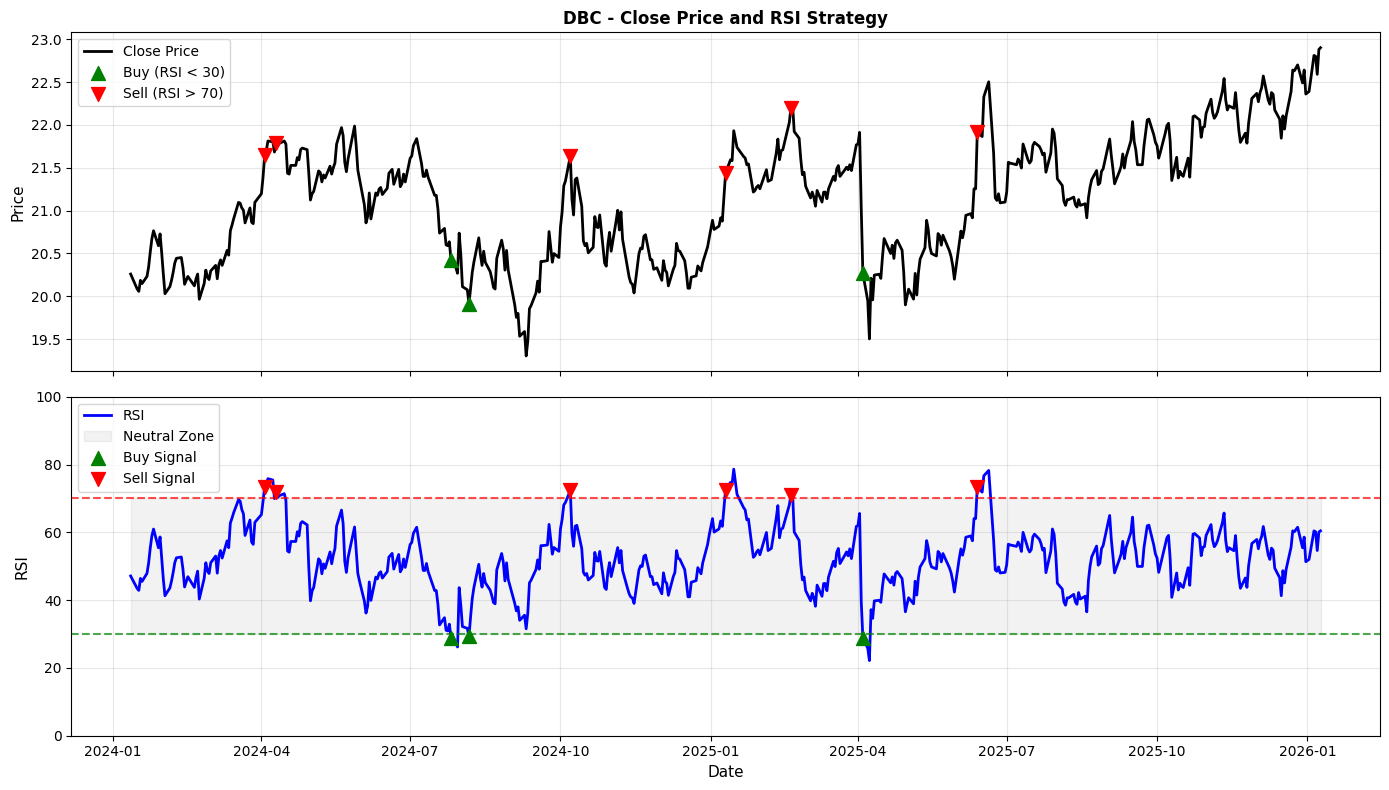

In [4]:
tk_plot = tickers[1]
df_plot = data_dict[tk_plot].tail(500)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# =========================
# CLOSE PRICE
# =========================
ax1.plot(df_plot.index, df_plot["close"], color="black", linewidth=2, label="Close Price")

# Buy markers (RSI < 30)
buy_signals = df_plot[df_plot["buy_signal"]]
ax1.scatter(buy_signals.index, buy_signals["close"], color="green", marker="^", 
            s=100, label="Buy (RSI < 30)", zorder=5)

# Sell markers (RSI > 70)
sell_signals = df_plot[df_plot["sell_signal"]]
ax1.scatter(sell_signals.index, sell_signals["close"], color="red", marker="v", 
            s=100, label="Sell (RSI > 70)", zorder=5)

ax1.set_ylabel("Price", fontsize=11)
ax1.set_title(f"{tk_plot} - Close Price and RSI Strategy", fontsize=12, fontweight="bold")
ax1.legend(loc="upper left", fontsize=10)
ax1.grid(True, alpha=0.3)

# =========================
# RSI
# =========================
ax2.plot(df_plot.index, df_plot["rsi"], color="blue", linewidth=2, label="RSI")

# RSI reference lines
ax2.axhline(y=70, color="red", linestyle="--", linewidth=1.5, alpha=0.7)
ax2.axhline(y=30, color="green", linestyle="--", linewidth=1.5, alpha=0.7)
ax2.fill_between(df_plot.index, 30, 70, alpha=0.1, color="gray", label="Neutral Zone")

# Buy / Sell markers on RSI
buy_signals_rsi = df_plot[df_plot["buy_signal"]]
ax2.scatter(buy_signals_rsi.index, buy_signals_rsi["rsi"], color="green", marker="^", 
            s=100, label="Buy Signal", zorder=5)

sell_signals_rsi = df_plot[df_plot["sell_signal"]]
ax2.scatter(sell_signals_rsi.index, sell_signals_rsi["rsi"], color="red", marker="v", 
            s=100, label="Sell Signal", zorder=5)

ax2.set_ylabel("RSI", fontsize=11)
ax2.set_xlabel("Date", fontsize=11)
ax2.set_ylim([0, 100])
ax2.legend(loc="upper left", fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'../images/RSI_sample.png')
plt.show()


In [5]:
def summarize(df_in):
       if df_in.empty:
           return df_in
       stats_mean = df_in.mean().tolist()
       stats_median = df_in.median().tolist()
       average_negative = df_in[df_in < 0].mean().tolist()
       average_positive = df_in[df_in > 0].mean().tolist()
       pct_positive = (df_in > 0).sum() / len(df_in)
       pct_positive = pct_positive.tolist()
       df_stats = pd.DataFrame(columns=df_in.columns)
       df_stats.loc['Média'] = stats_mean
       df_stats.loc['Mediana'] = stats_median
       df_stats.loc['Média dos Negativos'] = average_negative
       df_stats.loc['Média dos positivos'] = average_positive
       df_stats.loc['Porcentagem de Qtde. Positivos'] = pct_positive
       return df_stats

def fn_analyze_signals(df, price_col = 'close'):
    '''
    Compute returns following buy (signal==1) and sell (signal==-1) signals and
    return two DataFrames with statistics for multiple horizons.
    '''
    signals_long = 0
    signals_short = 0
    returns_long = {}
    returns_short = {}
    dates_loc = []
    max_horizon = 22
    horizons = [5, 10, 22]

    for i in range(0, (len(df) - max_horizon)):
        sig = df.get('signal').iloc[i] if 'signal' in df.columns else 0
        if sig == 1:
            signals_long += 1
            date = df.index[i].strftime('%Y-%m-%d')
            dates_loc.append(i)
            return_signal = []
            for h in horizons:
                return_signal.append((np.log(df[price_col].iloc[i + h]) - np.log(df[price_col].iloc[i])))
            returns_long[date] = return_signal
        elif sig == -1:
            signals_short += 1
            date = df.index[i].strftime('%Y-%m-%d')
            dates_loc.append(i)
            return_signal = []
            for h in horizons:
                return_signal.append((np.log(df[price_col].iloc[i + h]) - np.log(df[price_col].iloc[i])))
            returns_short[date] = return_signal

    # Build DataFrames where rows are signal dates and columns are horizons
    df_long = pd.DataFrame(returns_long).T if returns_long else pd.DataFrame()
    df_short = pd.DataFrame(returns_short).T if returns_short else pd.DataFrame()

    # Name columns by horizon for clarity
    col_names = [f'h_{h}' for h in horizons]
    if not df_long.empty:
        df_long.columns = col_names
    if not df_short.empty:
        df_short.columns = col_names


    df_stats_long = summarize(df_long)
    df_stats_short = summarize(df_short)

    return df_stats_long, df_stats_short,signals_long, signals_short

In [6]:
# Analyze all tickers in data_dict and store results keyed by ticker
stats_dict = {}
signals_counts = {}
dates_dict = {}
for tk, df_t in data_dict.items():
    try:
        df_long, df_short, signals_long, signals_short = fn_analyze_signals(df_t)
    except Exception as e:
        print(f'Error analyzing {tk}: {e}')
        stats_dict[tk] = {'long': pd.DataFrame(), 'short': pd.DataFrame()}
        dates_dict[tk] = []
        continue
    stats_dict[tk] = {'long': df_long, 'short': df_short}
    signals_counts[tk] = {'long': signals_long, 'short': signals_short}

In [7]:
from IPython.display import display, HTML
reports_html = []

for report_ticker in tickers:
    # Dados
    long_df = stats_dict.get(report_ticker, {}).get("long", pd.DataFrame()) * 100
    short_df = stats_dict.get(report_ticker, {}).get("short", pd.DataFrame()) * 100

    n_long = signals_counts.get(report_ticker, {}).get("long", 0)
    n_short = signals_counts.get(report_ticker, {}).get("short", 0)

    # Tabelas em HTML (estilo inline para melhor compatibilidade)
    if not long_df.empty:
        long_html = long_df.round(2).to_html(
            index=True,
            border=0,
            justify="left"
        )
    else:
        long_html = "<p><em>Nenhum sinal long identificado.</em></p>"

    if not short_df.empty:
        short_html = short_df.round(2).to_html(
            index=True,
            border=0,
            justify="left"
        )
    else:
        short_html = "<p><em>Nenhum sinal short identificado.</em></p>"

    # Bloco HTML final (1 coluna, mobile-first)
    html_block = f"""
<h2>{report_ticker} — Análise da Estratégia RSI</h2>

<p><strong>Resumo dos sinais</strong><br>
<strong>Sinais Long (sobrevenda):</strong> {n_long}<br>
<strong>Sinais Short (sobrecompra):</strong> {n_short}
</p>

<hr>

<h3>📈 Sinais Long — Retornos condicionais</h3>
{long_html}

<hr>

<h3>📉 Sinais Short — Retornos condicionais</h3>
{short_html}
"""

    reports_html.append(html_block.strip())


final_html_report = "\n\n<hr style='margin:32px 0;'>\n\n".join(reports_html)

display(HTML(final_html_report))



,h_5,h_10,h_22
Média,3.00,3.18,5.38
Mediana,1.78,2.12,3.08
Média dos Negativos,-6.50,-8.39,-7.90
Média dos positivos,9.65,10.65,13.95
Porcentagem de Qtde. Positivos,58.82,60.78,60.78
,h_5,h_10,h_22
Média,3.06,4.52,9.23
Mediana,1.75,3.10,6.68
Média dos Negativos,-3.46,-5.72,-8.04
Média dos positivos,6.56,8.95,16.04


In [8]:
for report_ticker in tickers:
    df_temp = data_dict[report_ticker].copy()
    df_temp['strategy'] = df_temp['signal_expanded'].shift(1) * df_temp['ret']
    data_dict[report_ticker] = df_temp
    

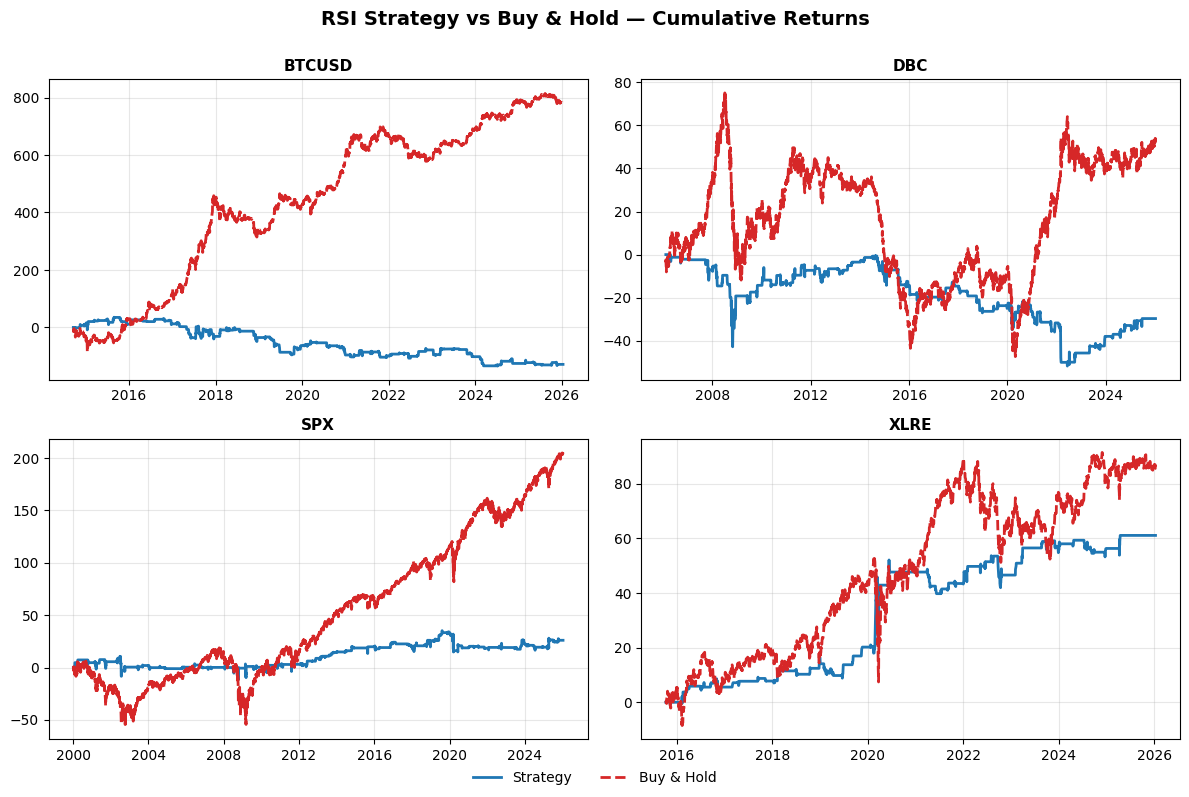

In [9]:
import matplotlib.pyplot as plt

# ======================================
# CONFIG
# ======================================
tickers_to_plot = tickers[:4]  # garante 4 ativos
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False, sharey=False)
axes = axes.flatten()

# ======================================
# LOOP DE PLOT
# ======================================
for ax, ticker in zip(axes, tickers_to_plot):
    df = data_dict[ticker].copy()

    # Retornos acumulados (%)
    strat_cum = df["strategy"].cumsum() * 100
    bh_cum    = df["ret"].cumsum() * 100

    ax.plot(df.index, strat_cum, linewidth=2, label="Strategy",color='tab:blue')
    ax.plot(df.index, bh_cum, linewidth=2, linestyle="--", label="Buy & Hold",color='tab:red')

    ax.set_title(ticker, fontsize=11, fontweight="bold")
    ax.grid(True, alpha=0.3)


# ======================================
# AJUSTES GERAIS
# ======================================
fig.suptitle(
    "RSI Strategy vs Buy & Hold — Cumulative Returns",
    fontsize=14,
    fontweight="bold"
)

# Legenda única
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=10
)

plt.tight_layout(rect=[0, 0.02, 1, 0.98])
plt.show()
